# Project: Do Recent Crime Activity Affect Property Prices?

Property prices are known to be a very volatile market and are well regarded to be dependant on economic factors such as interest rates, employment figures, supply and demand as well as demographics in the local region. What I'm interested in exploring in this mini-project is to assess the impact of recent crime activity to the fluctuations of property prices.

Using property data scraped from the Trulia API, as well as public government data on recent crime activity, I hope to be able to quantify and visualize the impact of crime activity to property prices.

# Exploring the Zillow API

An API I initially sought to explore was the Zilow API. The Zillow API offers various information on a particular piece of property including historical sales price as well as a price "Zestimate" of the property at any point in time. Ideally, we would like to use historical sales price as our standard measurement to assess price changes. After all, they are actual transcations and Zestimates are merely modelled using historical price patterns and external factors. Furthermore, Zestimates have been claimed to be a not-so-good proxy for actual prices (see here, here and here). That said, given the sporadic nature of actual sales (properties usually get sold once every few years, while crimes happen plenty of times a day), we will have to assume the Zestimate as the actual "price" of the property to make any sort of assessment.

To get the 30-day change in the price Zestimate of a property, we can use the following code:

In [25]:
import requests
def getZestimateChange30(zpid):
    key = "X1-ZWz1f42at2iccr_7vqv1"
    url = "http://www.zillow.com/webservice/GetZestimate.htm?zws-id=" + key + "&zpid=" + str(zpid) 
    request = requests.get(url)
    return request.text

However, I soon realized that it was difficult to get multiple listings in one go. In fact, Zillow requires all calls for property results to include an exact address, which makes gathering statistics of a neighborhood particularly troublesome. 

# Exploring the Trulia API

The Trulia API, on the other hand, appears to match exactly what I need. The API allows me to retrieve property price statistics at the city, county and neighborhood level over a period of time. Given that we are assessing property price fluctuations, and property are sold very sporadically, neighborhood-level data appears to be most appropriate.

We can get the statistics in XML format using the function below:

In [26]:
def getTruliaNeighborhoodStats(neighborhoodId, startDate, endDate):
    url_head = "http://api.trulia.com/webservices.php?library=TruliaStats&function=getNeighborhoodStats"
    neighbor = "&neighborhoodId=" + str(neighborhoodId)
    startDate = "&startDate=" + str(startDate)
    endDate = "&endDate=" + str(endDate)
    apiKey = "&apikey=98ary9am7d26tbf4easz65jp"
    url = url_head + neighbor + startDate + endDate + apiKey
    request = requests.get(url)
    return request.text

We also need to get all the neighborhoods in a particular city. The function below retrieves that information:

In [27]:
import pandas as pd
from bs4 import BeautifulSoup
def getNeighborhoodsInCity(city,state):
    url_head = "http://api.trulia.com/webservices.php?library=LocationInfo&function=getNeighborhoodsInCity"
    city = "&city=" + str(city)
    state = "&state=" + str(state)
    apiKey = "&apikey=98ary9am7d26tbf4easz65jp"
    url = url_head + city + state + apiKey
    request = requests.get(url)
    soup = BeautifulSoup(request.text, "lxml")
    neighborhoods = soup.find_all("neighborhood")
    ids = [x.find("id").text for x in neighborhoods]
    names = [x.find("name").text for x in neighborhoods]
    return pd.DataFrame(dict(ID=ids),index=names)

The function getCityPriceData returns a list of data frames containing property price history of the different neighborhoods of a city (and includes all the data cleaning):

In [28]:
def getCityPriceData(city,state,startDate,endDate):
    cityinfo = getNeighborhoodsInCity(city,state)
    data = []
    for neighid in cityinfo.ID:        
        # Get All Subcategory Nodes
        xmltext = getTruliaNeighborhoodStats(neighid,startDate,endDate)
        soup = BeautifulSoup(xmltext, "lxml")
        stat_data = soup.find_all("listingstat")
        dates = [x.weekendingdate.text for x in stat_data]
        mini_data = [x.find('type',text='All Properties').find_parent('subcategory') for x in stat_data]
        
        # Grab Data from the Subcategory Node
        numProperty = [int(x.numberofproperties.text) for x in mini_data]
        medianPrice = [float(x.medianlistingprice.text) for x in mini_data]
        avgPrice = [float(x.averagelistingprice.text) for x in mini_data]
        #to_delete = findDuplicateIndices(dates)
        
        mini_data = pd.DataFrame(dict(numProperty=numProperty,medianPrice=medianPrice,avgPrice=avgPrice),index=dates, dtype=float)
        mini_data = mini_data.reset_index().drop_duplicates(subset='index').set_index('index')
        data.append(mini_data)     
    
    return dict(zip(cityinfo.index,data))

The following example gets data from Jan 2014 to Mar 2014 for Ashbury Heights in San Francisco, CA:

In [8]:
data = getCityPriceData('Chicago','IL','2014-01-01','2014-02-28')
data['Cragin']

,avgPrice,medianPrice,numProperty
index,,,
2014-01-04,207180,190413,31
2014-01-11,220024,207900,27
2014-01-18,225708,215650,33
2014-01-25,227697,218220,33
2014-02-01,219725,198663,38
2014-02-08,219554,210488,39
2014-02-15,232451,248250,34
2014-02-22,243390,242050,32
2014-03-01,245656,237167,26


# Exploring Crime Data in Chicago

The city of Chicago has generally provided a dataset ('https://dev.socrata.com/foundry/#/data.cityofchicago.org/6zsd-86xi') containing all crime incidents from 2001 to the present. Each crime incident has a precise location and are classified into a particular type of crime. Such structured data makes it possible and fairly convenient to aggregate crime data with the housing data in neighborhoods of Chicago.

For instance, to get all crimes in Chicago during 2012, we can do the following:

In [29]:
import numpy as np
import urllib
import json

def getCrimeDataYear(year):
    limit = 50000
    master = pd.DataFrame()
    offset = 0
    while(True):
        url_head = "https://data.cityofchicago.org/resource/6zsd-86xi.json"
        text = "?$limit=" + str(limit) + "&$offset=" + str(offset) + "&year=" + str(year)
        url = url_head + text
        text = urllib.urlopen(url).read()
        data = pd.DataFrame(json.loads(text))
        master = master.append(data)
        offset += limit
        if(data.shape[0] < limit):
            break
    return master

In [13]:
master = getCrimeDataYear(2012)
master.shape
master.head(5)

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,latitude,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,False,0633,007XX E 91ST ST,HV136195,44,2012-01-27T23:00:00.000,OTHER OFFENSE,006,True,26,...,41.72923131,"{u'type': u'Point', u'coordinates': [-87.60554...",RESIDENCE,-87.605545655,OFFENSE INVOLVING CHILDREN,2012-02-15T14:45:24.000,6,1182909,1844763,2012
1,True,1014,016XX S HARDING AVE,HV136353,29,2012-01-28T22:45:00.000,AGGRAVATED:KNIFE/CUTTING INSTR,010,True,04B,...,41.858114826,"{u'type': u'Point', u'coordinates': [-87.72354...",SIDEWALK,-87.723542365,BATTERY,2012-01-30T19:07:44.000,24,1150367,1891477,2012
2,False,0424,031XX E 87TH ST,HV136452,46,2012-01-29T01:40:00.000,ARMED: HANDGUN,004,False,03,...,41.737541336,"{u'type': u'Point', u'coordinates': [-87.54766...",SIDEWALK,-87.547664037,ROBBERY,2016-01-10T15:52:27.000,7,1198681,1847930,2012
3,False,2221,018XX W 87TH ST,HV136384,71,2012-01-28T23:46:00.000,TO VEHICLE,022,True,14,...,41.735590072,"{u'type': u'Point', u'coordinates': [-87.66995...",VEHICLE NON-COMMERCIAL,-87.669950191,CRIMINAL DAMAGE,2012-02-02T12:45:36.000,21,1165311,1846938,2012
4,False,1834,0000X E GRAND AVE,HV136599,8,2012-01-29T06:30:00.000,DOMESTIC BATTERY SIMPLE,018,True,08B,...,41.891791928,"{u'type': u'Point', u'coordinates': [-87.62765...",HOTEL/MOTEL,-87.627656919,BATTERY,2012-02-01T13:57:42.000,42,1176387,1903949,2012


# Creating Comparable Crime and Property Data

# Part 1: Mapping Longitude/Latitude to Neighborhoods

Having explored both property and crime data, we need to combine the two datasets so that we can measure both property price changes and crime activity for a particular neighborhood over a period of time. Notice that while the Trulia dataset can be retrieved by neighborhood, the crime data only logs the location in lattitude and longitude. This calls for a need to convert lattitude and longitudes in Chicago to the appropriate neighborhood. Fortunately, Craig M. Booth's github contains scripts that map out the boundary of each neighborhood in Chicago, allowing us to map locations to neighborhoods. 

Running his script returns a json file which maps out each neighborhood by its boundary points. You can imagine the boundary points as the vertices of a polygon that the neighborhood encompasses.

In [21]:
import json
with open('community_areas.json') as data_file:    
    chicago_hoods = json.load(data_file)
chicago_hoods['Belmont Cragin'][::30]

[[-87.7414299950222, 41.9169848303604],
 [-87.7458549469705, 41.9144507974367],
 [-87.7533427514227, 41.9152558755319],
 [-87.7608208135131, 41.9162817038923],
 [-87.7688146552236, 41.9166862142488],
 [-87.781984824765, 41.9164906848003],
 [-87.7879451580112, 41.9169352675024],
 [-87.7903996577023, 41.9235085022744],
 [-87.790627825834, 41.9341121606875],
 [-87.7907588061843, 41.937919679274],
 [-87.7854463075709, 41.9383253338978],
 [-87.7718351731808, 41.938505036854],
 [-87.7602751469884, 41.9386539309],
 [-87.750412818822, 41.9387808745398],
 [-87.7422015255801, 41.9388904385381],
 [-87.7416879055474, 41.9257582720293]]

From Booth's github, we also have a function that determines whether a given location is inside a particular neighborhood, which as described above is mapped as a polygon.

In [34]:
def point_inside_polygon(x,y,poly):
    """Return True if the point described by x, y is inside of the polygon
    described by the list of points [(x0, y0), (x1, y1), ... (xn, yn)] in
    ``poly``
    Code from http://www.ariel.com.au/a/python-point-int-poly.html which
    in turn was adapted from C code found at
    http://local.wasp.uwa.edu.au/~pbourke/geometry/insidepoly/
    """
    n = len(poly)
    inside =False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

To check that the function works, we tested it on a random crime location in Chicago:

In [20]:
[e for i,e in enumerate(chicago_hoods.keys()) if point_inside_polygon(-87.706665329, 41.800781216, chicago_hoods[e])]

[u'Gage Park']

# Part 2: Matching Trulia-listed Neighborhoods to Chicago Open Portal Listed Neighborhoods

It is important to note, however, that the neighborhoods that Craig Booth obtained from the Chicago Open Data portal are not the same as the neighborhoods that Trulia has defined. These are the neighborhoods from Trulia that we were unable to identify exactly.

In [31]:
trulia_chicago_hoods = getNeighborhoodsInCity('Chicago','IL').index.values
check_hoods = [e for i, e in enumerate(trulia_chicago_hoods) if e not in chicago_hoods.keys()]
check_hoods[:5]

[u'Belmont Central',
 u'Canaryville',
 u'Cragin',
 u'DePaul',
 u'East Garfield Park']

We have no choice but to classify them to the Chicago neighborhood set on a case-by-case basis. It can be found in the function below:

In [32]:
mapping = ['Belmont Cragin','New City', 'Belmont Cragin','Sheffield & DePaul','Garfield Park','North Park','River North','Grand Crossing','South Deering','Lake View','Mckinley Park','River North','West Loop','River North','Lincoln Square','North Center','North Park','Ashburn','West Loop','West Loop','West Loop','Washington Heights','Englewood','Garfield Park','Rogers Park']
mapping = dict(zip(check_hoods,mapping))
mapping

{u'Belmont Central': 'Belmont Cragin',
 u'Canaryville': 'New City',
 u'Cragin': 'Belmont Cragin',
 u'DePaul': 'Sheffield & DePaul',
 u'East Garfield Park': 'Garfield Park',
 u'Forest Glen': 'North Park',
 u'Goose Island': 'River North',
 u'Greater Grand Crossing': 'Grand Crossing',
 u'Jeffrey Manor': 'South Deering',
 u'Lakeview': 'Lake View',
 u'McKinley Park': 'Mckinley Park',
 u'Near North Side': 'River North',
 u'Near West Side': 'West Loop',
 u'Pilsen': 'River North',
 u'Ravenswood': 'Lincoln Square',
 u'Roscoe Village': 'North Center',
 u'Sauganash': 'North Park',
 u'Scottsdale': 'Ashburn',
 u'Tri-Taylor': 'West Loop',
 u'Ukranian Village': 'West Loop',
 u'University Village': 'West Loop',
 u'Washington Heights - Brainerd': 'Washington Heights',
 u'West Englewood': 'Englewood',
 u'West Garfield Park': 'Garfield Park',
 u'West Rogers Park': 'Rogers Park'}

To test that we managed to map all Trulia neighborhoods, we do the following:

In [27]:
new_trulia_hoods = [mapping[x] if x in mapping else x for x in trulia_chicago_hoods]
new_check_hoods = [e for i, e in enumerate(new_trulia_hoods) if e not in chicago_hoods.keys()]
new_check_hoods

[]

Mapping neighborhoods that weren't listed to neighborhoods that are listed creates issues. In particular, Trulia data of two neighborhoods may now be referring to the same neighborhoods. As a result, we need to aggregate these datasets into one, which is implemented in combineTruliaData:

In [129]:
def combineTruliaData(data_new, data_original):
    indices = np.intersect1d(data_new.index,data_original.index)
    data_new = data_new.loc[indices]
    data_original = data_original.loc[indices]
    new_data = pd.DataFrame(columns=data_original.columns,index=indices)
    new_data['numProperty'] = data_new['numProperty']+data_original['numProperty']
    new_data['avgPrice'] = (1.*data_new['avgPrice']*data_new['numProperty'] + \
                           1.*data_original['avgPrice']*data_original['numProperty']) / \
                           new_data['numProperty']
    new_data['medianPrice'] = (1.*data_new['medianPrice']*data_new['medianPrice'] + \
                              1.*data_original['medianPrice']*data_original['medianPrice']) / \
                              new_data['numProperty']
    return new_data
        

# Part 3: Putting It Together

Now we put everything together by returning crime and Trulia data for a given year that contain the same neighborhoods. This way, we can compare crime and property prices easily.

The following function adds the corresponding Chicago neighborhood to the crime dataset:

In [30]:
def addNeighToDataset(data):
    longitude = data['longitude'].values
    latitude = data['latitude'].values
    region = []
    for locationx, locationy in zip(longitude,latitude):
        place = [e for i,e in enumerate(chicago_hoods.keys()) if point_inside_polygon(float(locationx), float(locationy), chicago_hoods[e])]
        if len(place) == 1:
            region.append(place[0])
        else:
            region.append('None')

    data['region'] = region
    return data

We can now create a full dataset given a particular year with the getFullData function. We also convert the dates to actual date objects so that we can filter the dataset easily when performing analyses.

In [130]:
from datetime import datetime
def getFullData(year):
    master = getCrimeDataYear(year)
    print str(master.shape[0]) + ' Crimes in ' + str(year)
    print "Crime Data Retrieved. Now assigning Neighborhoods"
    master = addNeighToDataset(master)
    print "Added Neighborhoods to Dataset. Now converting Date column to actual dates"
    master['date'] = [datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f') for x in master['date']]
    print "Converted Date column to actual dates. Now retrieve property data"
    trulia_data = getCityPriceData("Chicago","IL", str(year)+"-01-01", str(year)+"-12-31")    
    print "Retrieved Data. Now recombining data to match the correct neighborhoods"
    new_trulia_data = trulia_data.copy()
    for neighborhood,values in trulia_data.iteritems():
        if neighborhood in mapping.keys():
            new_neigh = mapping[neighborhood]
            if new_neigh not in new_trulia_data.keys():
                new_trulia_data[new_neigh] = trulia_data[neighborhood]
            else:
                new_trulia_data[new_neigh] = combineTruliaData(trulia_data[neighborhood],new_trulia_data[new_neigh])   
            del new_trulia_data[neighborhood]
    
    master.to_pickle("master")
    for neighborhood, values in new_trulia_data.iteritems():
        values.to_pickle("Trulia_" + neighborhood)
    
    return new_trulia_data #master,new_trulia_data



Using this function, we get crime and Trulia data from 2012-2015:

In [131]:
years = [2012,2013,2014,2015]
crime_data = []
property_data = []
for year in years:
    crime_year,property_year = getFullData(year)
    crime_data.append(crime_year)
    property_year = getFullData(year)
    property_data.append(property_year)

Retrieved Data. Now recombining data to match the correct neighborhoods
Retrieved Data. Now recombining data to match the correct neighborhoods
Retrieved Data. Now recombining data to match the correct neighborhoods
Retrieved Data. Now recombining data to match the correct neighborhoods


In [132]:
full_crime = pd.concat(crime_data)
property_neighs = property_data[0].keys()
full_property = dict()
for neigh in property_neighs:
    full_property[neigh] = pd.concat([x[neigh] for x in property_data])

# Analyzing the Data

Now that we have data, we can do some cool analyses!

# Question 1: Is there a relationship between Crime Rates and Property Prices?

Generally, we would hypothesize that more wealthy areas, which are reflected generally by property prices tend to have lower crime rates. Here, I will plot this data to see if this really is the case.

Before we make this comparison, we need to first calculate crime rate, which we define as the number of crimes that occurred over a period of time divided by the area's population. We got population data from an Excel form that we found on the Chicago Open Data website. Some data cleaning needed to be done, including mapping unlisted neighborhoods to the standard neighborhoods once again.

In [33]:
population_data = pd.read_csv('Chicago_Census.csv')
population_data['Neighborhood'] = [x.rstrip() for x in population_data['Neighborhood']]
population_data['Neighborhood'] = [mapping[x] if x in mapping.keys() else x for x in population_data['Neighborhood']]
population_data['Population'] = population_data.groupby('Neighborhood')['Population'].transform('sum')
population_data = population_data.drop_duplicates('Neighborhood')
population_data = population_data.set_index('Neighborhood')
population_data.head(5)

,Population
Neighborhood,
Rogers Park,54991
West Ridge,71942
Uptown,56362
Lincoln Square,39493
North Center,31867


The function createCrimePriceFrame aggregates both crime data, property data, and population data to get clean data for each Chicago neighborhood. We got a property price for each neighborhood by averaging all existing prices for that neighborhod from 2012-2015.

In [90]:
def createCrimePriceFrame(crimedata,propertydata):
    crimedata['date'] = pd.to_datetime(crimedata['date'])
    crimedata = crimedata.set_index('case_number')
    price_data = []
    population_num= []
    crime_num = []
    crime_ratio_data = []
    neighborhoods = []
    listings = []
    for neighborhood,values in propertydata.iteritems():
        if neighborhood in population_data.index.values:
            neighborhoods.append(neighborhood)
            price_data.append(np.mean(propertydata[neighborhood]['avgPrice']))
            population = float(population_data.loc[neighborhood]['Population'])
            crimes = crimedata[(crimedata['region'] == neighborhood)].shape[0]
            population_num.append(population)
            crime_num.append(crimes)
            crime_ratio_data.append(1.*crimes/population)
            listings.append(np.mean(propertydata[neighborhood]['numProperty']))

    return pd.DataFrame(zip(neighborhoods,price_data,crime_num,population_num,crime_ratio_data,listings), \
                        columns = ['Neighborhood','Price','Crimes','Population','Crime Ratio','Number of Listings'])
                   

Using this function, we can get clean statistics for each neighborhood:

In [357]:
neigh_summary = createCrimePriceFrame(full_crime,full_property)
neigh_summary = neigh_summary[np.isfinite(neigh_summary['Price'])]
neigh_summary.head(5)

,Neighborhood,Price,Crimes,Population,Crime Ratio,Number of Listings,1/Price,1/Price2,1/Price3
0,Montclare,204957.976415,2486,13426,0.185163,28.127358,0.000005,2.380512e-11,1.161463e-16
1,Calumet Heights,122355.584906,6568,13812,0.475529,36.226415,0.000008,6.679630e-11,5.459195e-16
2,North Park,454447.254551,3694,36439,0.101375,102.504717,0.000002,4.842092e-12,1.065490e-17
3,Rogers Park,210018.662426,16213,54991,0.294830,287.198113,0.000005,2.267171e-11,1.079509e-16
4,Clearing,178016.198113,4506,23139,0.194736,61.259434,0.000006,3.155593e-11,1.772644e-16


Plotting this data allows to see the relationship between crime activity and property prices:

In [140]:
import locale
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

def plot_crime_price_points(data,scale, pricemin, crimemin, ticksize, labelsize, titlesize, xmin, regression, param=False, titleend=""):
    locale.setlocale(locale.LC_ALL, 'en_US')

    sns.set_style("whitegrid")
    sns.set_context("poster")
    hfont = {'fontname':'Arial'}
    tfont = {'fontname':'Anja Meiners'}
    
    dotscale = 2
    sizes = [10,50,100,1000]
    
    fig, ax = plt.subplots()
    ax.scatter(data['Price']/scale,data['Crime Ratio'],marker='o',c='b', s=data['Number of Listings']/dotscale)
    for X, Y, Z, W in zip(data['Price'],data['Crime Ratio'],data['Neighborhood'], data['Number of Listings']):
        if X > pricemin or Y > crimemin:
            if Z == 'Washington Park':
                ax.annotate('{}'.format(Z), xy=(X/scale,Y), xytext=(np.log(W)*2, 5-np.log(W)/np.log(5)), ha='left', textcoords='offset points')
            else:
                ax.annotate('{}'.format(Z), xy=(X/scale,Y), xytext=(np.log(W)*2, -np.log(W)/np.log(5)), ha='left', textcoords='offset points')

    ax.set_xlabel('\nAverage Listing Price (in $'+locale.format("%d", scale, grouping=True)+'\'s)',fontsize=labelsize, **hfont)
    ax.set_ylabel('Crime Rate: Crimes / Person',fontsize=labelsize, **hfont)
    ax.set_xlim(left=xmin)
    if titleend == "":
        ax.set_title('\nHousing Prices vs. Crime Rate for Each Chicago Neighborhood\n',fontsize=titlesize, **hfont)
    else:
            ax.set_title('\nHousing Prices vs. Crime Rate for Each Chicago Neighborhood (' + titleend + ')\n',fontsize=titlesize, **hfont)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize) 
    
    l = [plt.scatter([],[], s=x/dotscale, edgecolors='none') for x in sizes]
    labels = [str(x) for x in sizes]

    leg = plt.legend(l, labels, ncol=4, frameon=True, fontsize=12,
    handlelength=2, loc = 1, borderpad = 1.8,
    handletextpad=1,title = 'Average Houses Listed\n', scatterpoints = 1)
    
    if regression != False and param != False:
        if type(param) == list:
            X = data[param]
        else:
            X = data[param].reshape(-1,1)
        y = regression.predict(X)
        pltdata = pd.DataFrame(zip(data['Price']/scale,y),columns=['X','y'])
        pltdata.sort('X',inplace=True)
        ax.plot(pltdata['X'],pltdata['y'],color='blue',linewidth=1)

        

/Users/haroldmli/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


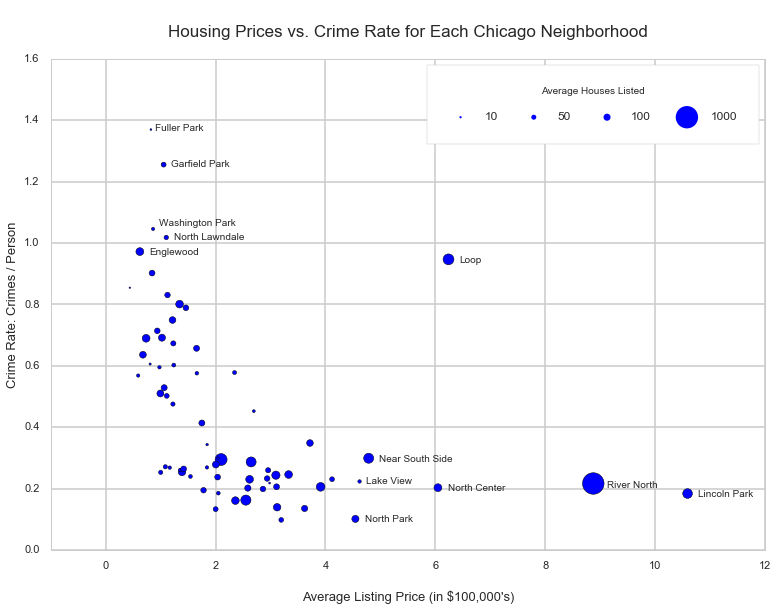

In [410]:
plot_crime_price_points(neigh_summary,1e5, 4.2e5, 0.92, 11, 13, 17, -1,False)

Indeed, this plot suggests that as property prices increase, crime rates tend to decrease. In fact, there seems to be a strong inverse relationship between these two variables. The big exception is the Loop neighborhood - while house prices are the 3rd highest in Chicago, it is also has the 6th highest crime rate. This makes sense as the Chicago Loop is the city's business center. While its residential population is not very high (30,000), far more people work in the district every day. As crime rate is the ratio between the number of crimes and residential population, Chicago Loop's crime rate is skewed upwards.

To plot the relationship, we performed ridge and lasso regression in an attempt to predict crime rate given property prices. It seems that regressing crime rate on inverse of price and inverse of price squared yields the best fit, further consolidating the claime that these two variables have an inverse relationship.

In [411]:
neigh_summary['1/Price'] = 1.0/neigh_summary['Price']
neigh_summary['1/Price2'] = 1.0/neigh_summary['Price']**2
neigh_summary.head(3)

,Neighborhood,Price,Crimes,Population,Crime Ratio,Number of Listings,1/Price,1/Price2,1/Price3,1/Crime,1/Crime2
0,Montclare,204957.976415,2486,13426,0.185163,28.127358,0.000005,2.380512e-11,1.161463e-16,5.400644,29.166951
1,Calumet Heights,122355.584906,6568,13812,0.475529,36.226415,0.000008,6.679630e-11,5.459195e-16,2.102923,4.422286
2,North Park,454447.254551,3694,36439,0.101375,102.504717,0.000002,4.842092e-12,1.065490e-17,9.864375,97.305887


Ridge Alpha: 3.16227766017e-10
R^2: 0.39858972056
Coefficients:
0.203576141311
[  3.62567578e+04   3.87720247e-01]


/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


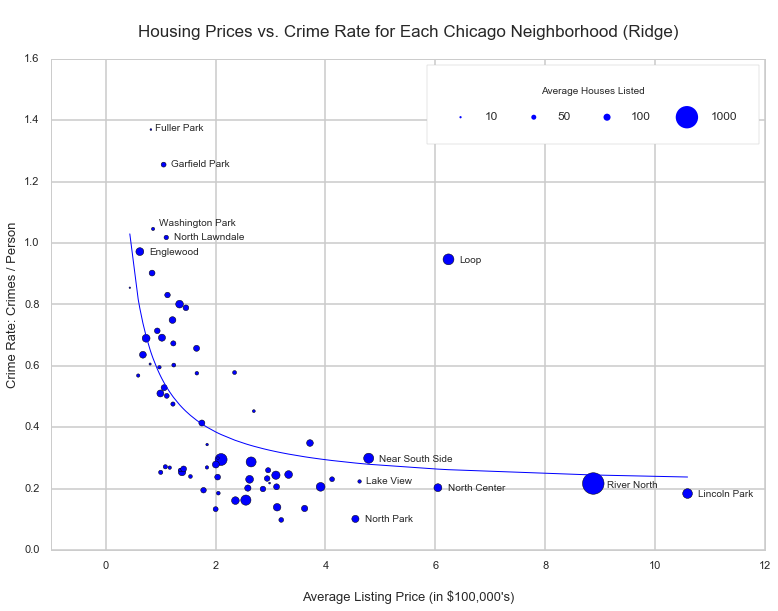

In [412]:
from sklearn import linear_model
n_folds = 5
variables = ['1/Price','1/Price2']
X = neigh_summary[variables]
y = neigh_summary['Crime Ratio'].values
clf_ridge = linear_model.RidgeCV(alphas=np.power(10.,np.arange(-15,1,0.1)),cv = n_folds)
clf_ridge.fit(X,y)       
print "Ridge Alpha: " + str(clf_ridge.alpha_)                                      
clf_ridge.predict(X)
print "R^2: " + str(clf_ridge.score(X,y))
print "Coefficients:"
print clf_ridge.intercept_
print clf_ridge.coef_
plot_crime_price_points(neigh_summary,1e5, 4.2e5, 0.92, 11, 13, 17, -1, clf_ridge, variables,\
                        titleend = 'Ridge')

Lasso Alpha: 1e-15
R^2: 0.441674563943
Coefficients:
0.0350398189635
[  7.76908561e+04  -1.73227719e+09]


/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


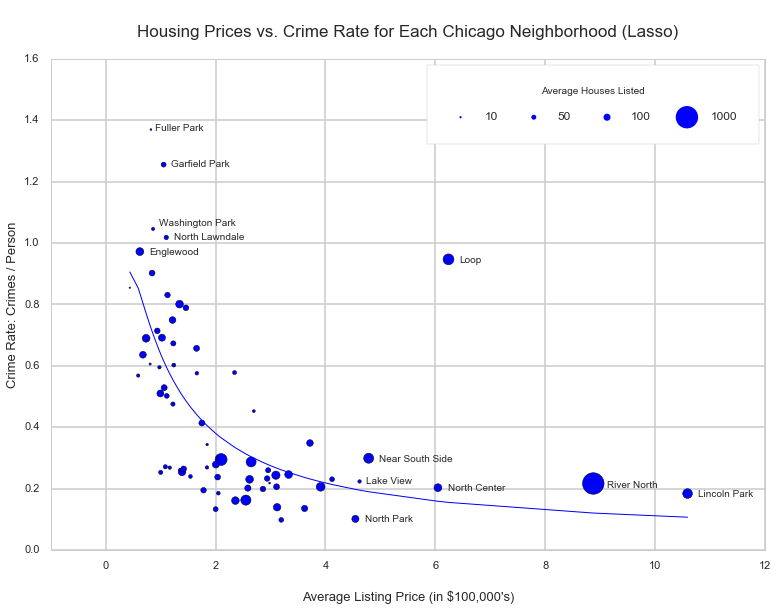

In [413]:
from sklearn import linear_model
n_folds = 5
variables = ['1/Price','1/Price2']
X = neigh_summary[variables]
y = neigh_summary['Crime Ratio'].values
clf_lasso = linear_model.LassoCV(alphas=np.power(10.,np.arange(-15,1,0.1)), cv=n_folds)
clf_lasso.fit(X,y)       
print "Lasso Alpha: " + str(clf_lasso.alpha_)                                      
clf_lasso.predict(X)
print "R^2: " + str(clf_lasso.score(X,y))
print 'Coefficients:'
print clf_lasso.intercept_
print clf_lasso.coef_
plot_crime_price_points(neigh_summary,1e5, 4.2e5, 0.92, 11, 13, 17, -1, clf_lasso, variables, \
                        titleend = 'Lasso')

It appears that lasso regression, the form of regularized regression that has a more acute shrinkage function (absolute value vs. squared values), resulted in a stronger fit. That said, the presence of two types of "outliers" - rich neighborhoods with low crime rates and poor neighborhoods with high crime rates has resulted in a fit that overestimates the rest of the communities (the cluster with less than $400k in house prices and 0.4 crime rate).

One can also argue that the graphs above does not portray crime activity accurately, because we need to account for the severity of the crime. So let's plot data for serious crimes only:

In [381]:
serious_crimes = ['ARSON','BATTERY','CRIM SEXUAL ASSAULT','HOMICIDE',\
                  'HUMAN TRAFFICKING','KIDNAPPING',\
                  'OFFENSE INVOLVING CHILDREN','PROSTITUTION','ROBBERY','SEX OFFENSE']

In [382]:
serious_crime_data = full_crime[full_crime['primary_type'].isin(serious_crimes)]
serious_neigh_summary = createCrimePriceFrame(serious_crime_data,full_property)
serious_neigh_summary = serious_neigh_summary[np.isfinite(serious_neigh_summary['Price'])]
serious_neigh_summary.head(5)

/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighborhood,Price,Crimes,Population,Crime Ratio,Number of Listings
0,Montclare,204957.976415,499,13426,0.037167,28.127358
1,Calumet Heights,122355.584906,1539,13812,0.111425,36.226415
2,North Park,454447.254551,615,36439,0.016878,102.504717
3,Rogers Park,210018.662426,4193,54991,0.076249,287.198113
4,Clearing,178016.198113,934,23139,0.040365,61.259434


In [414]:
serious_neigh_summary['1/Price'] = 1.0/serious_neigh_summary['Price']
serious_neigh_summary['1/Price2'] = 1.0/serious_neigh_summary['Price']**2
serious_neigh_summary.head(3)

,Neighborhood,Price,Crimes,Population,Crime Ratio,Number of Listings,1/Price,1/Price2,1/Crime,1/Crime2
0,Montclare,204957.976415,499,13426,0.037167,28.127358,0.000005,2.380512e-11,26.905812,723.922699
1,Calumet Heights,122355.584906,1539,13812,0.111425,36.226415,0.000008,6.679630e-11,8.974659,80.544502
2,North Park,454447.254551,615,36439,0.016878,102.504717,0.000002,4.842092e-12,59.250407,3510.610671


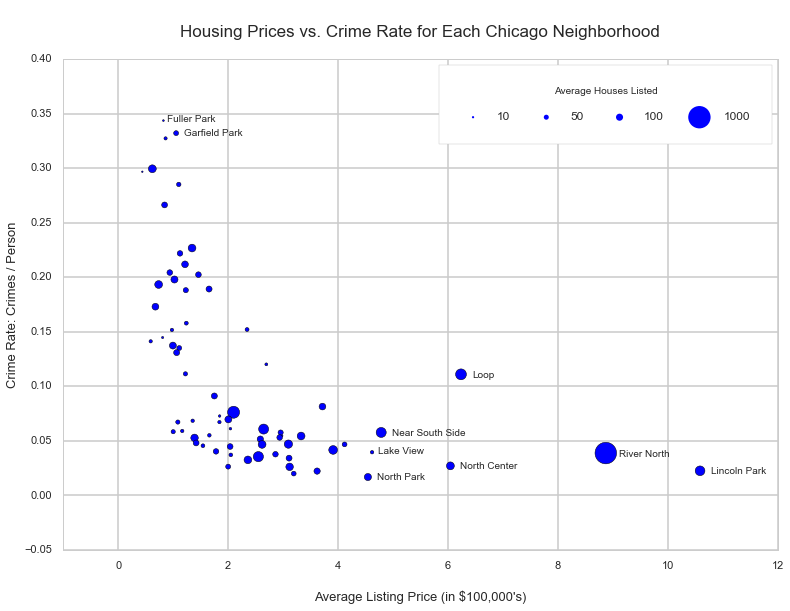

In [415]:
plot_crime_price_points(serious_neigh_summary,1e5, 4.2e5, 0.33, 11, 13, 17, -1,False)

Notice that the graph carries a similar shape, also suggesting an inverse relationship. Also observe that the big outlier (the Chicago Loop) is now less of an outlier, which makes sense -  the Chicago Loop is not known for serious violent crimes.

Ridge Alpha: 2.51188643151e-10
R^2: 0.517260386896
Coefficients:
0.025341120832
[  1.27622079e+04   1.49988741e-01]


/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


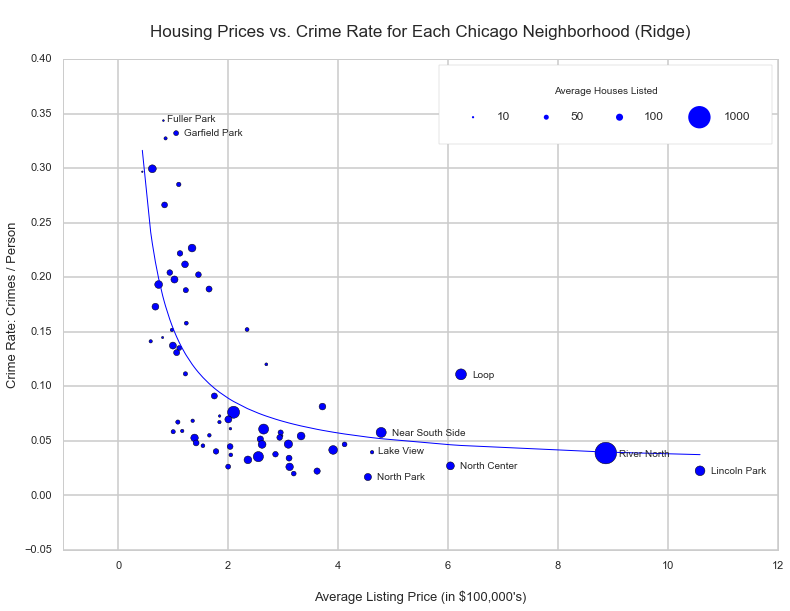

In [416]:
from sklearn import linear_model
n_folds = 5
variables = ['1/Price','1/Price2']
X = serious_neigh_summary[variables]
y = serious_neigh_summary['Crime Ratio'].values
clf_ridge = linear_model.RidgeCV(alphas=np.power(10.,np.arange(-15,1,0.1)),cv = n_folds)
clf_ridge.fit(X,y)       
print "Ridge Alpha: " + str(clf_ridge.alpha_)                                      
clf_ridge.predict(X)
print "R^2: " + str(clf_ridge.score(X,y))
print 'Coefficients:'
print clf_ridge.intercept_
print clf_ridge.coef_
plot_crime_price_points(serious_neigh_summary,1e5, 4.2e5, 0.33, 11, 13, 17, -1, clf_ridge, variables,\
                        titleend = 'Ridge')

Lasso Alpha: 6.3095734448e-14
R^2: 0.548843005716
Coefficients:
-0.0125206345854
[  2.15510067e+04  -3.33037462e+08]


/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


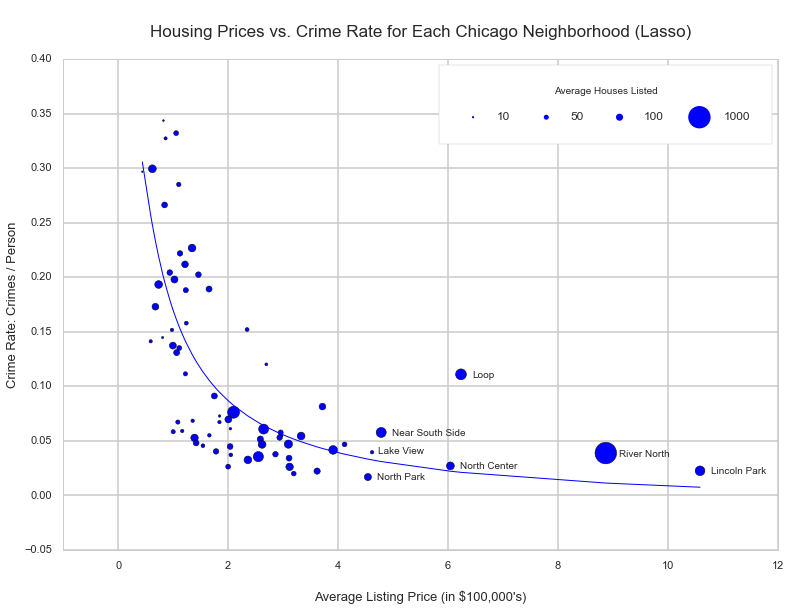

In [417]:
from sklearn import linear_model
n_folds = 5
variables = ['1/Price','1/Price2']
X = serious_neigh_summary[variables]
y = serious_neigh_summary['Crime Ratio'].values
clf_lasso = linear_model.LassoCV(alphas=np.power(10.,np.arange(-15,1,0.1)), cv=n_folds)
clf_lasso.fit(X,y)       
print "Lasso Alpha: " + str(clf_lasso.alpha_)                                      
clf_lasso.predict(X)
print "R^2: " + str(clf_lasso.score(X,y))
print 'Coefficients:'
print clf_lasso.intercept_
print clf_lasso.coef_
plot_crime_price_points(serious_neigh_summary,1e5, 4.2e5, 0.92, 11, 13, 17, -1, clf_lasso, variables, \
                        titleend = 'Lasso')

In this case, the lasso regression does better once again - and the fit to the data is also significantly better (R^2 of greater than 0.5), although it is likely due to the Chicago Loop being less of an outlier.

# Question 2 - Do increases/decreases in crime activity affect property prices?

We have seen how average property listing prices from Trulia has solid predictive power on crime rates in Chicago. I am also interested in the following - do changes in crime activity significantly affect property prices? Intuitively, this claim may be true - more crime activity would lead to the perception that the neighborhood is less safe to live in, thereby reducing demands for properties in the area, and causing house prices to fall.

To answer this question, we use our crime dataset to count the number of crimes that happen in the area over a period of time and our housing price dataset to measure the change in the average neighborhood listing price. The function createChangeDataSet generates this data over a period of times, measured in number of weeks.

To compare apples to apples, a neighborhood's crime / price change over a period of time is measured relative to the neighborhood's median change over the last 4 years (2012-2015).

In [515]:
def createChangeDataSet(crimedata,propertydata,numweeks):
    crimedata['date'] = pd.to_datetime(crimedata['date'])
    crimedata = crimedata.set_index('case_number')
    price_data = []
    actual_price_data = []
    date_data = []
    neighborhood_data = []
    crime_data = []
    for neighborhood,values in propertydata.iteritems():
        neigh_data = propertydata[neighborhood]
        neigh_data = neigh_data[neigh_data['avgPrice'] > 100]
        price_intervals = neigh_data['avgPrice']
        actual_prices = list(price_intervals[:-numweeks])
        price_changes = [1.*j/i-1 for i, j in zip(price_intervals[:-numweeks], price_intervals[numweeks:])] 
        price_changes = [x - np.median(price_changes) for x in price_changes]
        full_dates = neigh_data.index.values
        hood_dates = list(full_dates[:-numweeks])
        crimes = []
        for i,j in zip(full_dates[:-numweeks], full_dates[numweeks:]):
            crimes.append(float(crimedata[(crimedata['region'] == neighborhood) & \
                      (crimedata['date'] >= i + ' 00:00:00') & \
                      (crimedata['date'] < j + ' 00:00:00')].shape[0]))
        crimes = [x/np.median(crimes)-1 for x in crimes]
        price_data += price_changes
        date_data += hood_dates
        neighborhood_data += [neighborhood] * len(price_changes)
        crime_data += list(crimes)
        actual_price_data += actual_prices
    
    data = pd.DataFrame(zip(neighborhood_data,date_data,price_data,crime_data, actual_price_data), \
                        columns = ['Neighborhood','Date','Price Change','Crime Activity','Actual Prices'])
    
    return data

With this function we plot 4-week changes in crime activity and price changes:

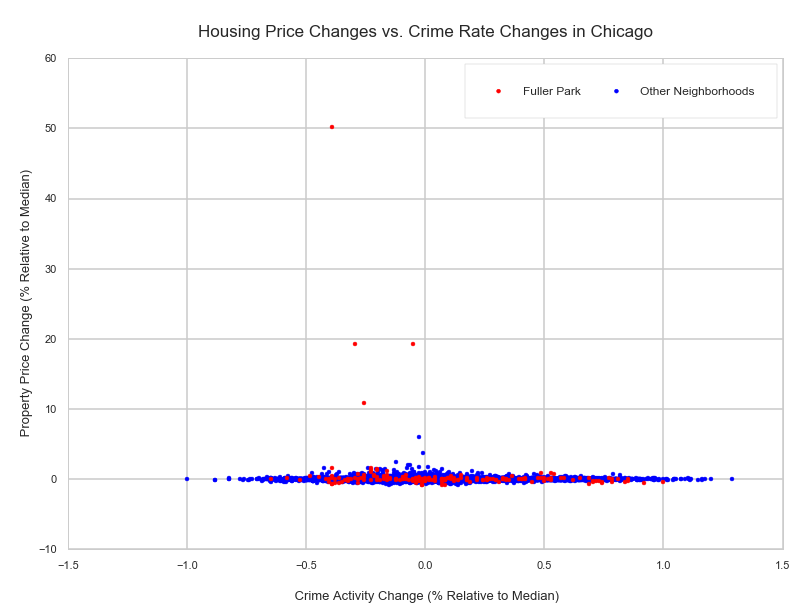

In [548]:
data_change_4 = createChangeDataSet(full_crime,full_property,4)

labelsize = 13
ticksize = 11
titlesize = 17

hfont = {'fontname':'Arial'}
tfont = {'fontname':'Anja Meiners'}

non_fuller_data = data_change_4[data_change_4['Neighborhood'] != 'Fuller Park']
X = non_fuller_data['Crime Activity']
y = non_fuller_data['Price Change']
p1 = plt.scatter(X,y, color='blue',s=15)

fuller_data = data_change_4[data_change_4['Neighborhood'] == 'Fuller Park']
p2 = plt.scatter(fuller_data['Crime Activity'], fuller_data['Price Change'], color='red', s=15)

leg = plt.legend([p2,p1], ['Fuller Park','Other Neighborhoods'], ncol=4, frameon=True, fontsize=12,
    handlelength=2, loc = 1, borderpad = 1.8,
    handletextpad=1, scatterpoints = 1)

plt.xlabel('\n Crime Activity Change (% Relative to Median)',fontsize=labelsize, **hfont)
plt.ylabel('\n Property Price Change (% Relative to Median)',fontsize=labelsize, **hfont)
plt.tick_params(labelsize=ticksize)
plt.title('\nHousing Price Changes vs. Crime Rate Changes in Chicago\n',fontsize=titlesize, **hfont)

Notice that there are plenty of outliers on the price change dimension - and it turns out that all of the outliers are from the Fuller Park neighborhood, mainly due to its low property prices (average of less than $100k) and the small number of properties Trulia was able to sample (less than 10). Thus, we remove it from our analysis and get the following:

Intercept: 0.00975438820012
Slope: -0.00273822495871
Correlation: -0.0048369955887


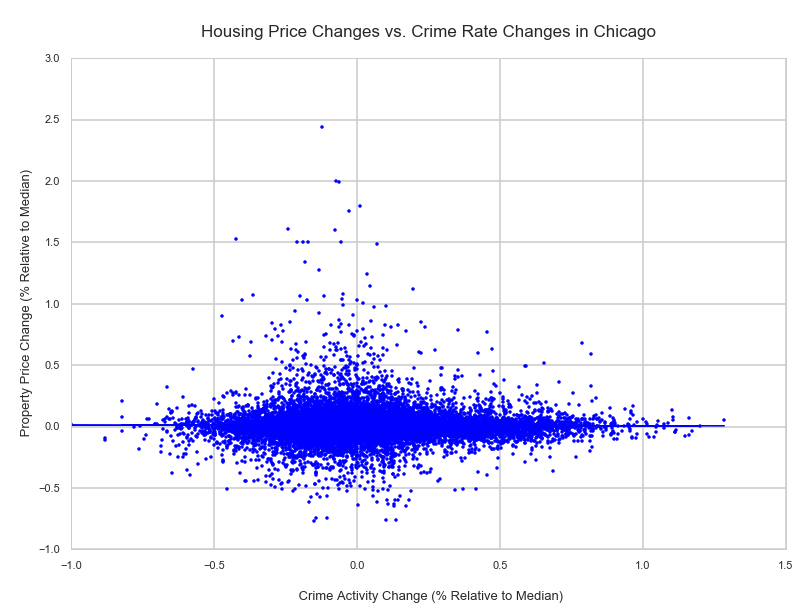

In [552]:
clean_data_change_4 = data_change_4[data_change_4['Neighborhood'] != 'Fuller Park']
X = clean_data_change_4['Crime Activity']
y = clean_data_change_4['Price Change']
fit = np.polyfit(X,y,1)
fit_fn = np.poly1d(fit)
plt.plot(X,y, 'bo', X, fit_fn(X), '-b', ms=3.5, linewidth = 1)

plt.xlabel('\n Crime Activity Change (% Relative to Median)',fontsize=labelsize, **hfont)
plt.ylabel('\n Property Price Change (% Relative to Median)',fontsize=labelsize, **hfont)
plt.tick_params(labelsize=ticksize)
plt.title('\nHousing Price Changes vs. Crime Rate Changes in Chicago\n',fontsize=titlesize, **hfont)
plt.ylim(-1,3) # There are Crime Activity Change of over 500%, but we don't need to display them
print 'Intercept: ' + str(fit[1])
print 'Slope: ' + str(fit[0])
print 'Correlation: ' + str(np.corrcoef(X, y)[0,1])

Here, we see that the regression line is essentially flat and the points are quite evenly scattered across the board, suggesting that crime changes is a poor indication of property price changes.

Again, one can argue that including only serious crimes may help our case. So let's re-run the analysis using only serious crimes. Since there are less serious crimes, we increased the time period to 8 weeks so that we can collect more crime data.

Intercept: 0.0134584857378
Slope: -0.00544830440991
Correlation: -0.00845996566411


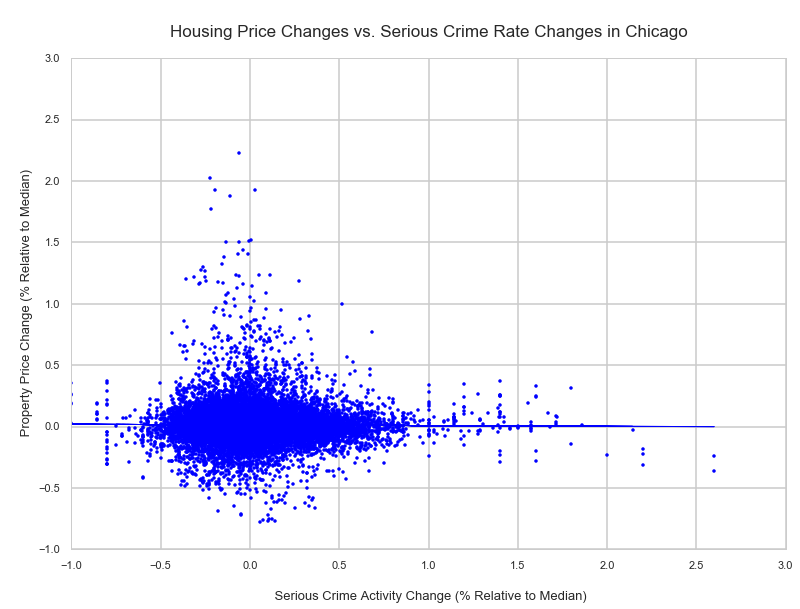

In [553]:
serious_data_change_8 = createChangeDataSet(serious_crime_data,full_property,8)
clean_serious_data_change_8 = serious_data_change_8[serious_data_change_8['Neighborhood'] != 'Fuller Park']
X = clean_serious_data_change_8['Crime Activity']
y = clean_serious_data_change_8['Price Change']
fit = np.polyfit(X,y,1)
fit_fn = np.poly1d(fit)
plt.plot(X,y, 'bo', X, fit_fn(X), '-b', ms=3.5, linewidth = 1)
plt.xlabel('\n Serious Crime Activity Change (% Relative to Median)',fontsize=labelsize, **hfont)
plt.ylabel('\n Property Price Change (% Relative to Median)',fontsize=labelsize, **hfont)
plt.tick_params(labelsize=ticksize)
plt.title('\nHousing Price Changes vs. Serious Crime Rate Changes in Chicago\n',fontsize=titlesize, **hfont)
plt.ylim(-1,3) # There are Crime Activity Change of over 500%, but we don't need to display them
print 'Intercept: ' + str(fit[1])
print 'Slope: ' + str(fit[0])
print 'Correlation: ' + str(np.corrcoef(X, y)[0,1])

Again, the relationship between these two variables is very weak. Thus, we conclude that changes in crime rates do not significantly affect property prices.

# Question 3: How does crime rate vary throughout a week?

All our life - parents have told us to be more vigilant during night time because more  crimes happen in the dark. Is that really true? If so, which parts of the night is the most treacherous? Does crime activity differ on weekdays compared to weekends? Using the Chicago crime dataset we can try to figure that out.

The following function reads in the full crime dataset, and segregates the crime data by neighborhood and time of the week in hours (168 different groups).

In [627]:
numHours = 24
numDays = 7

def createCrimeHourWeeklyData(crimedata):
    neighborhoods = crimedata['region'].unique()
    neighborhoods = [mapping[x] if x in mapping.keys() else x for x in neighborhoods]
    hrs = [str(x) for x in range(0,numHours*numDays)]
    weeklyData = pd.DataFrame(0.,index=neighborhoods,columns=hrs)

    for index, row in crimedata.iterrows():
        week_index = row['date'].weekday()*numHours + row['date'].hour
        neigh = row['region']
        if neigh in mapping.keys():
            neigh = mapping[neigh]
        if neigh in population_data.index:
            weeklyData[str(week_index)][neigh] = weeklyData[str(week_index)][neigh] + \
                                                 1./population_data['Population'][neigh]
    return weeklyData    
    

In [34]:
hourly_data = createCrimeHourWeeklyData(full_crime)
hourly_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
Chatham,0.005576,0.003126,0.002288,0.001902,0.001611,0.001321,0.002030,0.003062,0.004802,0.006188,...,0.004963,0.006220,0.006639,0.005028,0.005543,0.006059,0.006156,0.006414,0.006220,0.004641
North Lawndale,0.006210,0.003425,0.002339,0.002283,0.001476,0.001197,0.004233,0.002590,0.005764,0.006739,...,0.006405,0.006293,0.006739,0.006572,0.007713,0.009078,0.007296,0.007491,0.006237,0.006321
South Chicago,0.005481,0.002660,0.002564,0.001859,0.001186,0.001186,0.001282,0.002628,0.003269,0.004552,...,0.004391,0.004039,0.005000,0.005161,0.005449,0.005353,0.005834,0.006090,0.005096,0.003750
Auburn Gresham,0.005375,0.003344,0.002031,0.001518,0.001272,0.001169,0.001846,0.002749,0.004103,0.004185,...,0.004390,0.004247,0.004862,0.004226,0.004349,0.005088,0.004842,0.004349,0.005991,0.004329
River North,0.001702,0.001081,0.001118,0.001093,0.000398,0.000323,0.000398,0.000572,0.000969,0.001255,...,0.001081,0.001429,0.001019,0.001143,0.001230,0.001205,0.001329,0.001044,0.001156,0.000919


The following functions returns a data frame for a neighborhood, with the dimensions being days and hour of day respectively.

In [5]:
def singleNeighborhoodHourlyData(neighborhood):
    hours, days, numWeekdays, numWeekends, clock = 24, 7, 5, 2, 12
    data_array = hourly_data.loc[neighborhood].values.reshape(days,hours)
    isWeekday = ['True']*numWeekdays + ['False']*numWeekends
    column_name = [x % clock + (x % clock == 0)*clock for x in range(0,hours)]
    column_name[:clock] = [str(x) + " AM" for x in column_name[:clock]]
    column_name[clock:] = [str(x) + " PM" for x in column_name[clock:]]
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df = pd.DataFrame(data_array,columns=column_name)
    df['Weekday'] = isWeekday
    df['Day'] = days
    return df, column_name

The following function draws a polygon given latitudes and longitudes, so that a neighborhood can be geographically represented:

In [299]:
def draw_screen_poly(lats, lons, rate):
    max_rate = 0.005
    xy = zip(lons,lats)
    poly = Polygon( xy, facecolor=(rate/max_rate,1-rate/max_rate,0), alpha=0.5 )
    plt.gca().add_patch(poly)

Using the functions, I created a preliminary visualization that shows crime rates on Monday 3 am. This graph unfortunately lacks interactiveness - i.e. I can't switch the time of the week and see the changes update live.

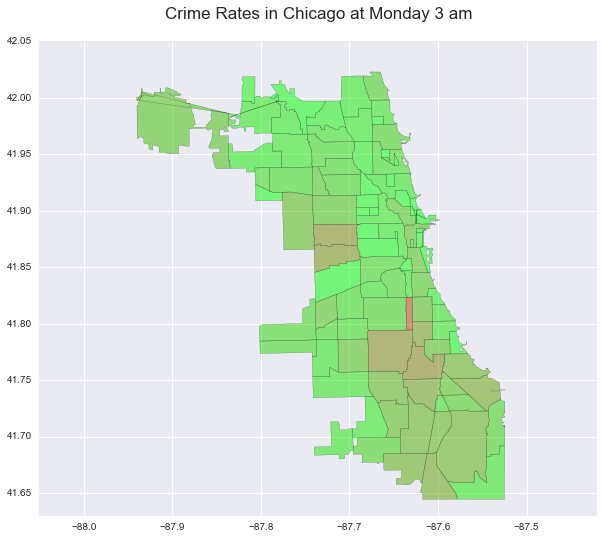

In [300]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8.5
max_val = -1
for neighborhood, data in chicago_hoods.iteritems():
    df,hour_times = singleNeighborhoodHourlyData(neighborhood)
    draw_screen_poly([x[1] for x in data], [x[0] for x in data],df['3 AM'][0])
    max_val = max(df[hour_times].values.max(),max_val)
plt.xlim(-88.05,-87.42)
plt.ylim(41.63,42.05)
plt.title('Crime Rates in Chicago at Monday 3 am\n', fontsize=17)


# Interactive Version of Circular Graph

For this reason we use Bokeh Widgets and its many functionalities to create an interactive graph. The data structure needs to be altered dramatically, as we need to store all the data for all the different neighborhoods. 

Part of the implementation included using CustomJS, where we use Javascript to update the data source when a different neighborhood is chosen. The data source contains all existing data plus a 'current' dataframe which is displayed on the graph. When a new neighborhood is chosen, the 'current' dataframe gets updated and the correct data is thus shown. 


Side note: This is a small snippet that cleans the dataset - we take out any neighborhoods that don't have any crime data.

In [35]:
row_sum = hourly_data.sum(axis=1)
good_neigh = row_sum[row_sum!=0].index
new_hourly_data = hourly_data.loc[good_neigh.values]

In [19]:
from bokeh.models.widgets import Select,Dropdown,VBox
from bokeh.io import output_file, show, vform
from bokeh.embed import components
from bokeh.session import Session
from bokeh.embed import autoload_server
from bokeh.plotting import figure, show, ColumnDataSource, cursession, output_server
from bokeh.models import HoverTool, CustomJS

session = Session()
raw_data = new_hourly_data.copy()/4 # Make it annual

is_weekday = {
    "True" : "#aeaeb8",
    "False" : "#e69584",
}

width = 800
height = 800
inner_radius = 90
outer_radius = 300 - 10
rounding = 1./0.001
hours = 24
days = 7

big_angle = 2.0 * np.pi / (days + 1)

small_angle = big_angle / hours
day_abbv = ['MON','TUE','WED','THU','FRI','SAT','SUN']

dfMax = raw_data.max(axis=1)*1.05
raw_data = raw_data.divide(dfMax, axis=0)*(outer_radius-inner_radius) + inner_radius
keys = list(raw_data.index.values)
keys += ['current']
values = list(raw_data.values)
values += [raw_data.loc['Chatham'].values]

labels = [list(np.arange(0,x+1e-15,(x+1e-15)/6)*1e5) for x in dfMax]
radii = [list(inner_radius + (outer_radius-inner_radius)*np.array(x)/y/1e5) for x,y in zip(labels,dfMax)]
for i,label in enumerate(labels):
    labels[i] = [int(x) for x in label]

keys2 = []
values2 = []
for i,neigh in enumerate(raw_data.index.values):
    keys2 += [neigh + '_labels', neigh + '_radii']
    values2 += [labels[i],radii[i]]
keys2 += ['current_labels','current_radii']
values2 += [labels[0],radii[0]]

keys3 = list(raw_data.index.values)
values3 = [[x + ' Annual Crime Rate by Hour (per 100,000 people)'] for x in list(raw_data.index.values)]
keys3 += ['current']
values3 += [['Chatham Annual Crime Rate by Hour (per 100,000 people)']]
    
source = ColumnDataSource(data=dict(zip(keys,values)))
source2 = ColumnDataSource(data=dict(zip(keys2,values2)))
source3 = ColumnDataSource(data=dict(zip(keys3,values3)))

p = figure(plot_width=width, plot_height=height, title="",
        x_axis_type=None, y_axis_type=None,
        x_range=(-420, 420), y_range=(-420, 420),
        min_border=0, outline_line_color="black")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = np.pi/2 - big_angle/2 - df.index.to_series()*big_angle
colors = [is_weekday[day] for day in df.Weekday]
p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
)

# small wedges
p.annular_wedge(0, 0, inner_radius, 'current',
            -big_angle+(np.pi/2 - big_angle/2 - 7*big_angle)-np.arange(1,hours*days+1,1)*small_angle,
            -big_angle+(np.pi/2 - big_angle/2 - 7*big_angle)-np.arange(0,hours*days,1)*small_angle, 
            color='#b22222',source=source)

# circular axes and lables
p.circle(0, 0, radius='current_radii', fill_color=None, line_color="white",source=source2)

p.text(0, 'current_radii', 'current_labels',
           text_font_size="8pt", text_align="center", text_baseline="middle",source=source2)
p.arc(0,0,'current_radii',start_angle=-big_angle/2+np.pi/2+np.pi*3/180,end_angle=-np.pi*5/180+np.pi/2,
          direction='anticlock',color='black',source=source2)
p.arc(0,0,'current_radii',start_angle=np.pi*5/180+np.pi/2,end_angle=big_angle/2+np.pi/2-np.pi*3/180,
          direction='anticlock',color='black',source=source2)


# radial axes
p.annular_wedge(0, 0, inner_radius-10, outer_radius+20,
                -big_angle+angles, -big_angle+angles, color="black")
p.annular_wedge(0, 0, inner_radius-10, outer_radius+20,
                -big_angle+ np.pi/2 - big_angle/2 - len(df)*big_angle, 
                -big_angle+ np.pi/2 - big_angle/2 - len(df)*big_angle, color="black")

# 6AM, Noon and 6 PM Radial Axes
p.annular_wedge(0, 0, inner_radius, outer_radius,
                -big_angle+angles+small_angle*6, -big_angle+angles+small_angle*6, color="gray")
p.annular_wedge(0, 0, inner_radius, outer_radius,
                -big_angle+angles+small_angle*12, -big_angle+angles+small_angle*12, color="gray")
p.annular_wedge(0, 0, inner_radius, outer_radius,
                -big_angle+angles+small_angle*18, -big_angle+angles+small_angle*18, color="gray")


# Day labels
xr = inner_radius*0.8*np.cos(np.array(-big_angle/2 + angles))
yr = inner_radius*0.8*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles-np.pi/2)
p.text(xr, yr, day_abbv, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

xr = outer_radius*1.05*np.cos(np.array(-big_angle/2 + angles + small_angle*6))
yr = outer_radius*1.05*np.sin(np.array(-big_angle/2 + angles + small_angle*6))
label_angle=np.array(-big_angle/2+angles-np.pi/2 + small_angle*6)
p.text(xr, yr, ['6AM']*days, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

xr = outer_radius*1.05*np.cos(np.array(-big_angle/2 + angles))
yr = outer_radius*1.05*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles-np.pi/2)
p.text(xr, yr, ['12PM']*days, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

xr = outer_radius*1.05*np.cos(np.array(-big_angle/2 + angles - small_angle*6))
yr = outer_radius*1.05*np.sin(np.array(-big_angle/2 + angles - small_angle*6))
label_angle=np.array(-big_angle/2+angles-np.pi/2 - small_angle*6)
p.text(xr, yr, ['6PM']*days, angle=label_angle,
       text_font_size="8pt", text_align="center", text_baseline="middle")

# Insert Title
p.text(0, 420*0.82, 'current',
       text_font_size="14pt", text_align="center", text_baseline="middle",source=source3)
    
callback = CustomJS(args=dict(source=source,source2=source2,source3=source3), code="""
        var data = source.get('data');
        var f = cb_obj.get('value')
        data['current'] = data[f]
        source.trigger('change');        
        var data2 = source2.get('data');
        var f = cb_obj.get('value')
        data2['current_radii'] = data2[f+'_radii']
        data2['current_labels'] = data2[f+'_labels']
        source2.trigger('change');
        var data3 = source3.get('data');
        var f = cb_obj.get('value')
        data3['current'] = data3[f]
        source3.trigger('change')
    """)

selection = Select(title="Choose Neighborhood:", value="Chatham", options=list(raw_data.index.values),callback=callback)
layout = vform(VBox(selection), p)
output_file("Chicago_circular_hourly_time.html", 
            title="Chicago_circular_hourly_time.py")
show(layout)


Using saved session configuration for http://localhost:5006/
To override, pass 'load_from_config=False' to Session


# Interactive Version of Map

This code shows the crime rates in a map format. Implementation is very similar to the circular graph map - again, we are storing all the data in a data source with a 'current' data source that updates when a new time of the week is chosen.

In [24]:
from bokeh.models import HoverTool, CustomJS
from bokeh.plotting import figure, show, ColumnDataSource, cursession, output_server
from bokeh.io import output_notebook, hplot
from bokeh.embed import notebook_div
from bokeh.models.widgets import Dropdown, VBox
from bokeh.resources import CDN
from bokeh.embed import file_html

import math
import time
colors = ["#FFADAD", "#FF9999","#FF8585", "#FF7070", "#FF6161", "#FF4747", "#FF1111","#F50000"]

days = 7
neighborhoods = []
neigh_xs = []
neigh_ys = []
crime_rates_full = []
neigh_colors_full = []

daysOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
keys = []
for neighborhood, data in chicago_hoods.iteritems():
    neigh_xs.append([x[0] for x in data])
    neigh_ys.append([x[1] for x in data])
    neighborhoods.append(neighborhood)
for day in range(0,days):
    for hour in hour_times:
        keys += [daysOfWeek[day] + " " + hour]
        crime_rates = []
        for neighborhood, data in chicago_hoods.iteritems():
            df,times = singleNeighborhoodHourlyData(neighborhood)
            crime_rates.append(100000.*df[hour][day]/4)

        neigh_colors_full.append([colors[int(math.floor(i/max(crime_rates)/1.001*len(colors)))] for i in crime_rates])
        crime_rates_full.append(crime_rates)

key_crime = [x + '_crime' for x in keys]
key_color = [x + '_color' for x in keys]

full_keys = key_color + key_crime + ['current_color','current_crime','neighborhoods','xs','ys']
full_values = neigh_colors_full + crime_rates_full + \
              [neigh_colors_full[0],crime_rates_full[0],neighborhoods,neigh_xs,neigh_ys]


source = ColumnDataSource(data=dict(zip(full_keys,full_values)))
source2 = ColumnDataSource(data=dict(day='Monday',hour='12 AM'))

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="Chicago Crime Rate (per 100,000 people)",title_text_font_size='14pt',tools=TOOLS)
  
p.patches('xs', 'ys', source=source,
              fill_color='current_color', fill_alpha=0.7,
              line_color="white", line_width=0.5, name = 'patch')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Neighborhood", "@neighborhoods"),
    ("Crime Rate", "@current_crime")
]

callback = CustomJS(args=dict(source=source,source2=source2), code="""
        var data = source.get('data');
        var data2 = source2.get('data');
        var f = cb_obj.get('value')
        var hour = data2['hour']
        data2['day'] = f
        data['current_color'] = data[f+' '+ hour + '_color']
        data['current_crime'] = data[f+' '+ hour + '_crime']
        source.trigger('change');
        source2.trigger('change');
    """)

callback2 = CustomJS(args=dict(source=source,source2=source2), code="""
        var data = source.get('data');
        var data2 = source2.get('data');
        var f = cb_obj.get('value')
        var day = data2['day']
        data2['hour'] = f
        data['current_color'] = data[day + ' ' + f + '_color']
        data['current_crime'] = data[day + ' ' + f + '_crime']
        source.trigger('change');      
        source2.trigger('change');
    """)

selectionDay = Select(value='Monday', options=daysOfWeek,callback=callback)
selectionHour = Select(value='12 AM', options=hour_times,callback=callback2)
menu_bar = hplot(VBox(selectionDay), VBox(selectionHour))
layout = vform(menu_bar, p)
output_file("Chicago_map_hourly_time.html", 
                title="Chicago_map_hourly_time.py")
show(layout)
    
html = file_html(layout, CDN, "my plot")


ERROR:/Users/haroldmli/anaconda/lib/python2.7/site-packages/bokeh/validation/check.pyc:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 80c9a363-5d0d-4b9d-aeb9-c2eaeedc34fb
ERROR:/Users/haroldmli/anaconda/lib/python2.7/site-packages/bokeh/validation/check.pyc:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 80c9a363-5d0d-4b9d-aeb9-c2eaeedc34fb


So that's it - this concludes  my analysis on Chicago crime rates and housing prices. Happy to get feedback on any of this code (I'm still a beginner and learning as much as I can) and any suggestions on how to make even more interesting analyses!